# Introduction

The interest rate is one of the most important economic indicators. Every (potential) real estate owner is affected by the interest rate - if the interest rate is high, it will be costlier to borrow money to buy real estate and hence, the prices of real estate will decrease. It is therefore interesting to examine how the central bank set the interest rate. 

In reality, the central bank in most countries cannot independently set the interest rate. Denmark e.g. has a fixed exchange rate policy against the euro and do only change the interest rate to keep this exchange rate fixed. Small and medium size economies are most likely dependent of export and must therefore also consider the effect of a change in the exchange rate if they adjust the interest rate. 
Only the largest economies are able to set the optimal interest rate without considering other economies. In these cases, Taylor (1993) defined how the central bank should set the optimal interest rate. Number of different equations for the optimal interest rate have been proposed afterwards, but we consider a simple Taylor rule given by

$i_t = \bar{r} + b(\pi_t - \pi^*) + h(y_t - \bar{y}) + \epsilon _t$

where $i$ is the nominal interest rate, and $\bar{r}$ is the interest rate in steady state (where there is neither an inflation gap nor an output gap). $\pi$ is the inflation rate, and $\pi^*$ is the inflation target set by the central bank. $y$ is the log of real GDP, and $\bar{y}$ is the log of potential GDP. We denote each period with $t$. The parameters $b$ and $h$ express the weight put on the inflation gap and the output gap (a large value of $b$ relative to $h$ implies that the central bank weights the inflation gap higher than the output gap when determining the optimal interest rate). The error term, $\epsilon$, is assumed to be a white noise process with mean zero and variance $\sigma_{\epsilon}$. 

In the first step, we import data and structure the data, so we are able to conduct the analysis. 
Afterwards, we examine the evolution of the interest rate since 1954. We estimate the parameters of $\bar{r}$, $b$ and $h$ by different methods. Finally, we consider how the choice of period changes the parameter values and determine if it looks like the central bank follows a Taylor rule. 

# Data

In this project we use data for the effective Fed funds rate, the consumer price index for all urban consumers (CPI), the real GDP and the potential GDP, all for the US. We use data from July 1954, as this is the first period where we can obtain data for the potential GDP until late 2018.

We will import our data by using `pandas_datareader` from which there is remote access to FRED's statistics.



In [25]:
# 1) Import the pandas_datareader.data package and the datetime package (makes it possible to manipulate date format)
import pandas_datareader.data as web
from datetime import datetime

# 2) Choose the period the data should be obtained for.
#(The cpi starts three month before the other vaiables because we have to calculate the inflation for the first period.)
start = datetime(1954, 7, 1)
start_cpi = datetime(1954, 4, 1)
end = datetime(2018, 10, 1)
end_funds = datetime(2018, 12, 1)

# 3) Import the data.  
funds    = web.DataReader('FEDFUNDS', 'fred', start, end_funds)
cpi      = web.DataReader('CPIAUCSL', 'fred', start_cpi, end)
gdp_real = web.DataReader('GDPC1', 'fred', start, end)
gdp_pot  = web.DataReader('GDPPOT', 'fred', start, end)

The funds data is given by monthly observations. In order to get quarterly data, we calculate the mean of the funds rate of every three month (later on we keep only quarterly observations). 

In [26]:
# 1) Calculate the mean of the funds rate. 
funds['i'] = funds['FEDFUNDS'].rolling(3, min_periods=3).mean().shift(-2)

We note that the index type is given as a DatetimeIndex. This implies that we can use the  ".month" function in order to keep the relevant months. As we consider quarterly data, we only want to keep the three-month average of the funds rate in the four quarters of the year, and thus we only keep observations from January (Q1), April (Q2), July (Q3) and October (Q4).  

We plot the data by using `matplotlib`.

In [27]:
# 1) We print the type of the index in order to determine how to deal with the index later on.
print(type(funds.index))

# 2) Since the index is given by the DatetimeIndex, we apply the '.month' function in order to only 
# consider quarterly observations.
funds = funds[(funds.index.month == 1) | (funds.index.month == 4) | 
      (funds.index.month == 7) | (funds.index.month == 10)]

# 3) We import the matplotlib package (makes it possible to plot data)
import matplotlib.pyplot as plt

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Now, the evolution of the funds rate on quarterly basis can be examined. 

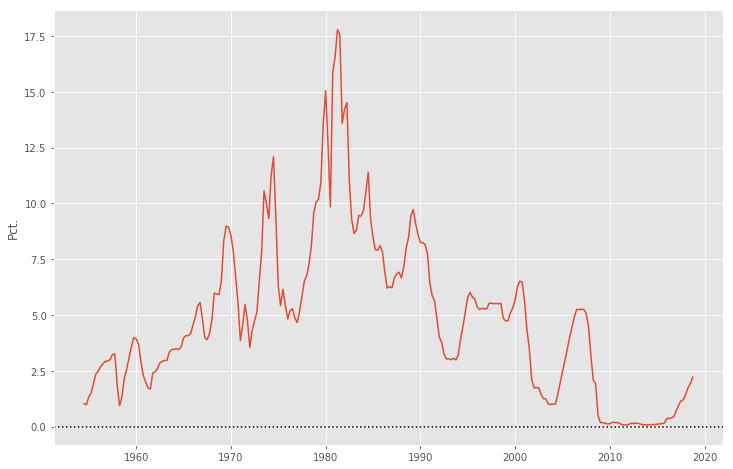

In [28]:
# 2) We are now able to plot the funds rate given by quarterly data. 
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.ylabel('Pct.')
plt.plot(funds['i'])
axes_cpi = plt.gca()
axes_cpi.axhline(y=0, color='black', linestyle=":")
plt.show()

The consumer price index is given by monthly observations. In order to calculate the inflation in Q1, we consider the relative change in the consumer price index from October the previous year to January the current year. Thus, we calculate the relative change in the consumer price index three months before (later on we keep only quarterly observations). 

In [29]:
# 1) Calculate the relative change in the consumer price index three months before by applying the '.pct_change' function.
cpi['pi'] = cpi['CPIAUCSL'].pct_change(periods=3)

We only want to keep quarterly observations. In the same way as we did with the funds rate, we only keep observations in January (Q1), April (Q2), July (Q3) and October (Q4) and drop all other observations. 
Afterwards, we only keep observations from the relevant period (i.e., we delete the first row since we only consider the funds rate from Q3 in 1954. 

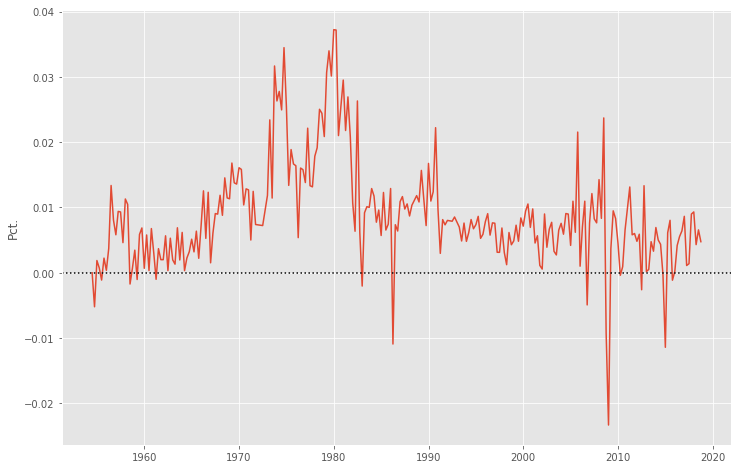

In [30]:
# 1) Since the index is given by the DatetimeIndex, we apply the '.month' function in order to only 
# consider quarterly observations (to only consider quarterly data, we use observations from January (Q1), 
# April (Q2), July (Q3) and October (Q4). 
cpi = cpi[(cpi.index.month == 1) | (cpi.index.month == 4) | 
      (cpi.index.month == 7) | (cpi.index.month == 10)]

# 2) We only want to keep observations from Q3 in 1954. Thus, we keep every row except of the first row. 
cpi = cpi.iloc[1:]

# 3) Plot the inflation rate
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.ylabel('Pct.')
plt.plot(cpi['pi'])
axes_cpi = plt.gca()
axes_cpi.axhline(y=0, color='black', linestyle=":")
plt.show()

We want to combine the data sets in order to get one data set with all the relevant variables. We use the ".join" function where we merge the four different datasets by their indices. We start by combining the funds rate and the consumer price index. Afterwards, we add the real GDP and lastly, we add the potential GDP. 

We use "outer join" in order to keep observations in either or both data sets. We consider the same period in all four datasets, so we will not get any missing values. 

In the end, we only keep the relevant variables and rename the variables, so the variable names are in line with the theory.

In [31]:
# 1) Combine the funds rate and the consumer price index. 
combined = funds.join(cpi, how='outer')

# 2) Add the real GDP. 
combined = combined.join(gdp_real, how='outer')

# 3) Add the potential GDP (after this step we have a dataset with the required variables).
combined = combined.join(gdp_pot, how='outer')

# 4) Drop the funds rate where we did not calculate the average and the consumer price index. 
drop_these = ['FEDFUNDS', 'CPIAUCSL']
combined.drop(drop_these, axis=1, inplace=True)

# 5) Rename the variables so they are in line with theory. 
combined.rename(columns = {'GDPC1' : 'Y', 'GDPPOT' : 'Y_bar'}, inplace=True)

# 6) Ensure that we (only) have the required variables. 
combined.head(5)

,i,pi,Y,Y_bar
DATE,,,,
1954-07-01,1.026667,0.000000,2682.601,2729.3
1954-10-01,0.986667,-0.005212,2735.091,2745.3
1955-01-01,1.343333,0.001871,2813.212,2762.3
1955-04-01,1.500000,0.000747,2858.988,2779.1
1955-07-01,1.940000,-0.001120,2897.598,2796.0


In order to estimate the parameter of $h$, we are not to consider absolute values of the GDP. By taking logs of $Y$ and $\bar{Y}$, we consider relative values of the real GDP and the potential GDP in line with the literature. Thus, we apply a transformation where $y \equiv log(Y)$ and $\bar{y} \equiv log(\bar{Y})$.
We note that the inflation target is estimated to 4.04 percent every year in Clarida et al. (1998). Thus, we generate the quarterly inflation target by taking the quartic root of 1.0404. The choice of inflation target will not affect the estimates of $b$ or $h$, but only reduce the estimate of $\bar{r}$ by $b \pi^{*}$.

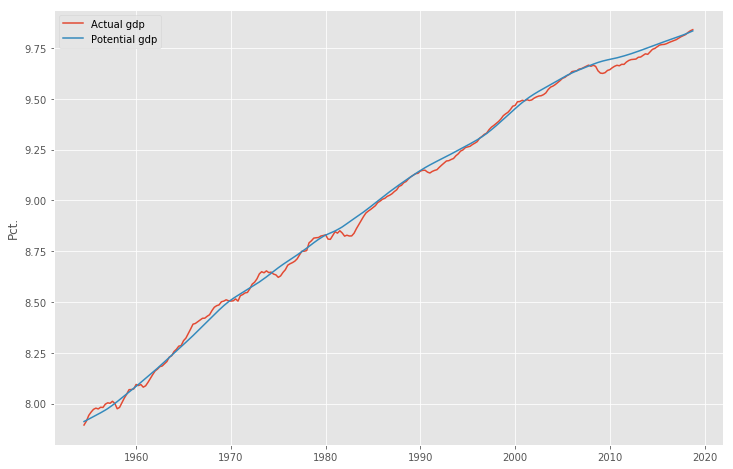

In [33]:
import numpy as np
# 1) Take logs of Y and Y_bar.
combined['y'] = np.log(combined['Y'])
combined['y_bar'] = np.log(combined['Y_bar'])

# 2) Drop the absolute values of the real GDP and the potential GDP since they are unimportant for the analysis.
drop_those = ['Y', 'Y_bar']
combined.drop(drop_those, axis=1, inplace=True)

# 3) Find the inflation target on quarterly basis. 
combined['pi_star']=(1+0.0404)**(1/4)-1

# 4) Plot actual GDP and potential GDP. 
plt.figure(figsize=(12,8))
plt.plot(combined['y'])
plt.plot(combined['y_bar'])
plt.ylabel('Pct.')
plt.legend(['Actual gdp','Potential gdp'])
plt.show()

Before we begin with the analysis, we ensure that the data set looks like it is supposed to.

In [34]:
# Ensure that we (only) have the required variables in order to conduct the analysis. 
combined.head(5)

,i,pi,y,y_bar,pi_star
DATE,,,,,
1954-07-01,1.026667,0.000000,7.894542,7.911800,0.00995
1954-10-01,0.986667,-0.005212,7.913920,7.917646,0.00995
1955-01-01,1.343333,0.001871,7.942082,7.923819,0.00995
1955-04-01,1.500000,0.000747,7.958223,7.929882,0.00995
1955-07-01,1.940000,-0.001120,7.971637,7.935945,0.00995


# Analysis

In this section we want to analyze the data. We will apply the Taylor rule to the data and estimate the parameters. First, we select the period that we want to examine. We will do this by applying an interactive slider. We use the
"SelectionRangeSlider" function from `ipywidgets` package. This function makes it possible to select a range from a given list. We will define this list as the period we imported in the data from the data section. 

We will set the standard period to the period used in Clarida et al. (1998) which is 1982-1994. However, one can change the time period in order to examine how the estimated Taylor rule changes when a new period is chosen. 

In [35]:
# 1) Import ipywidgets for widgets and pandas for creating the data range.
import ipywidgets as widgets
from ipywidgets import interact, interactive
import pandas as pd

# 2) Choose start date and end date for the list.
start_date = datetime(1954, 4, 1)
end_date = datetime(2018, 12, 30)

# 3) Define a DatatimeIndex (dates) from start_date to end_range with a item for every quarter.
#    Makes this DatatimeIndex into a list (options). Set the standard range to the the period estimated in 
#    Clarida et al. (1998) (index).
dates = pd.date_range(start_date, end_date, freq='q')
options = [(date.strftime('%Y'), date) for date in dates]
index = (113, len(options)-96)

# 4) Generate the widget for selecting time interval.
h = widgets.SelectionRangeSlider(
    options=options,
    index = index,
    description='Time interval',
)

# 5) Generate a column with the dates from the index.
combined.reset_index(inplace=True)

We want to define a function that generates a data set in the chosen time period, applies the Taylor rule to the data set, and plot the interest rate and the estimated Taylor rule.
Note that the estimated Taylor rule changes when different values of $\bar{r}$, $b$ and $h$ are chosen in the slider. 

In [36]:
# 1) Define a function that applies the Taylor rule with some parameters to the data set selected below with 
#    the interactive graph.
def taylor_apply(r=0.97, b=0.56, h=0.83):
    """ Applies the Taylor rule to the data. """
    
    def taylor(row):
        """ Defines the Taylor rule as a function of the data and the choice of parameters.
        Returns the Taylor rule. """
        
        pi_star = (1+0.02)**(1/4)-1
        return r+(b*(row['pi']-pi_star)+h*(row['y']-row['y_bar']))*100
    
    select_data.com_sel['taylor'] = select_data.com_sel.apply(taylor, axis=1)
    return

# 2) Define a function that plots the interest rate and the Taylor rule with some parameters for the selected data set.
def graph(r, b, h):
    """ This function plots the ineterest rule as a function of the variables and the choice of parameter values. """
    
    taylor_apply(r, b, h)
    plt.figure(figsize=(12,8))
    plt.plot('DATE', 'i', data=select_data.com_sel)
    plt.plot('DATE', 'taylor', data=select_data.com_sel)
    plt.legend(['Feds funds rate','Estimated Taylor'])
    plt.ylabel('Pct.')
    axes_cpi = plt.gca()
    axes_cpi.axhline(y=0, color='black', linestyle=":")
    return

# 3) Define a function that selects a data set that is between two dates, applies the Taylor rule to the data set, and 
#    plot the interest rate and the estimated Taylor rule.
def select_data(time, r=9.7, b=0.56, h=0.83):
    """ This function generates a data set in the selected period, applies the Taylor rule to the data set, and 
    plots the interest rate and the estimated Taylor rule. """
    
# 4) Select the start date and the end date from the slider. The slider gives an output which first element is the 
#    start date and the second element is the end date.
    start_date = time[0]
    end_date = time[1]
    
# 5) Generate a series/condition (select_data.mask) which is true if a date is between the start date and the end date.
#    Create a data set for all observations that satisfy the condition.
    select_data.mask = (combined['DATE'] > start_date) & (combined['DATE'] <= end_date)
    select_data.com_sel = combined.loc[select_data.mask].copy()
    
# 6) Generate a function for the Taylor rule and apply this function to the data set the obey the condition.
    graph(r, b, h)

widgets.interact(select_data, 
    time = h,
    r=(0.0,20,0.1), b=(0.0,6.0,0.01), h=(0.0,6.0,0.01) 
); 

interactive(children=(SelectionRangeSlider(description='Time interval', index=(113, 162), options=(('1954', Ti…

In order to estimate the parameters of $\bar{r}$, $b$ and $h$, we use numerical optimization. 
First, we take some initial guess of the values of the parameters and set the number of iterations. The first iteration generates a difference between the estimated funds rate and the actual funds rate. The sum of the squared differences in every period is saved. In the next iteration, we draw a value from the uniform distribution in a range of probable parameter values. If these values have decreased the total sum of squared differences between the estimated funds rate and the actual funds rate, we store the parameter values. This procedure is repeated $N$ number of times. 
We note that we have to estimate the parameters simultaneously in order to get interior solutions. 

In [37]:
# 1) Define the function and document it
def guess_optimize(b=1,h=1,r=0.01,maxitter=5000):
    """ This function initializes a set of initial parameter values. In the first iteration, the squared difference between
    the estimated funds rate and the actual funds rate is calculated. The sum of the squared differences is saved. 
    In the following iterations, we draw a set of parameter values from the uniform distribtuion calibrated to a
    probable range. If the sum of squared residuals is less than the previous iterations, we store the paramter values.
    We do this N number of times, and in the end, we get the parameter values that minimizes the difference between 
    estimated funds rate and the acutal funds rate. """
    
    # 2) Set a seed in order to replicate data. 
    np.random.seed(118)
   
    # 3) Start by iteration 0.  
    t = 0
    
    # 4) Take an initial guess of the parameter values. 
    b = 1
    h = 1
    r = 0.01
    
    # 5) Set the initial best guess equal to a large number (so we should expect that this is improved already
    # in the first iteration).
    error_best = 100000
    b_best = 1
    h_best = 1
    r_best = 0.01
    
    # 6) We only want to continue the iterations if we have not reached the defined maximum number of iterations. 
    while True: 
        if t>=maxitter:
            
            # 7) Print the optimal parameter values as a table and plot the Feds fund rate and the Taylor rule
            guess_optimize.r_best = r_best
            guess_optimize.b_best = b_best
            guess_optimize.h_best = h_best
            graph(r_best,b_best,h_best)
            guess_optimize.para = [' ','r','b','h']
            guess_optimize.result = [' guess','{:6.3f}'.format(round(r_best, 3)),'{:6.3f}'.format(round(b_best, 3)),'{:6.3f}'.format(round(h_best, 3))]
            for x,y in zip(guess_optimize.para, guess_optimize.result):
                print(x,y)
            break

        # 8) Draw numbers from the uniform distribution in a probable range. 
        b = np.random.uniform()*3
        h = np.random.uniform()*3
        r = np.random.uniform()*10
        
        # 9) Apply the Taylor Rule.
        taylor_apply(r, b, h)
        
        # 10) Calculate the squared error term (squared difference between actual funds rate and estimated funds rate).
        select_data.com_sel['error'] = select_data.com_sel['i'] - select_data.com_sel['taylor']
        select_data.com_sel['error2'] = select_data.com_sel['error']**2

        # 11) Calculate sum of errors.
        sum_error = select_data.com_sel['error2'].sum()

        # 12) Only store parameter values if the difference in the sum of squared residuals are less than before.
        if sum_error<error_best:
            error_best=sum_error
            r_best = r
            b_best = b
            h_best = h
            t_best = t
        
        # 13) Conduct one more iteration if the maximum number of iterations have not been reached.
        t += 1

    return


The function is defined above. We set the number of iterations and store the estimated parameters. 

   guess
r  6.571
b  1.235
h  0.005


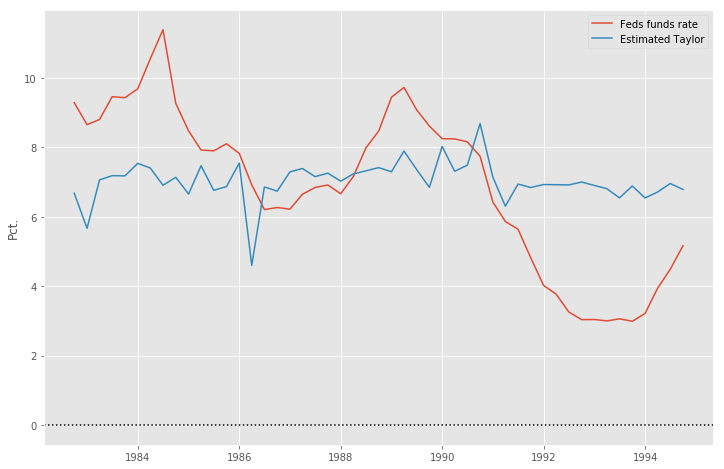

In [38]:
# 1) Set the number of iterations and store the estimated parameters (try more iterations to get a better fit). 
error = guess_optimize(maxitter=5000)

In order to get the parameter values that ensures that the estimated funds rate is closest to the actual funds rate, we apply the OLS-estimator (we disregard the fact that the variables need to cointegrate, and that the GMM-estimator is most likely more advantageous to apply if we expect that the agents have forward looking expectations). 

We will first try to estimate the parameters with our own OLS estimator using the minimize function from the `scipy` package. We do that by applying two functions; one function where we calculate the sum of squared differences and another, where we apply the Taylor rule to the data. In the end, we print the estimates of $\bar{r}$, $b$ and $h$. 

   guess   mini
r  6.571  7.114
b  1.235  1.333
h  0.005  0.027


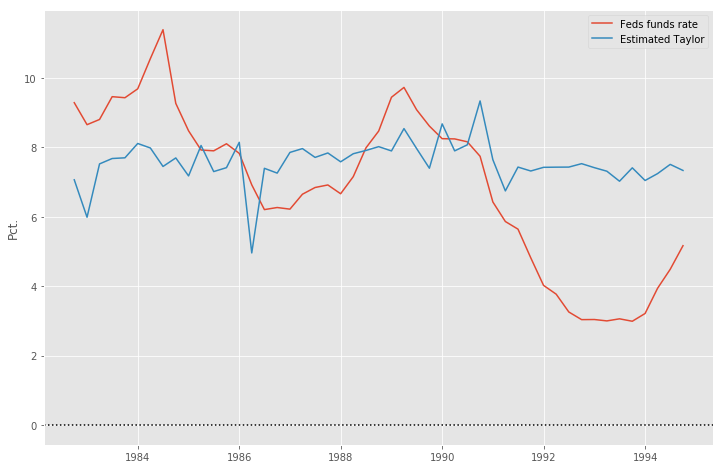

In [39]:
# 1) Import the optimize function
from scipy import optimize

# 2) Define a function that calculate the sum of squared differences for given parameters of r, b and h.
def f(params):
    """ This function calculates the sum of squared differences and returns the sum of the squared differences 
    throughout the period. """
    r, b, h = params
    
# 3) Apply the Taylor rule to the data set selected earlier
    def taylor2(row):
        """ Applies the Taylor rule to the data set that represents the time period chosen. """
        return r+(b*(row['pi']-row['pi_star'])+h*(row['y']-row['y_bar']))*100
    
    select_data.com_sel['taylor'] = select_data.com_sel.apply(taylor2, axis=1)

    # 4) Calculate the difference between the estimated Taylor point and the actual fund rate (error)
    select_data.com_sel['error'] = select_data.com_sel['i'] - select_data.com_sel['taylor']
    select_data.com_sel['error2'] = select_data.com_sel['error']**2

    # 5) Calculate sum of the squared differences
    sum_error = select_data.com_sel['error2'].sum()
    return sum_error

# 6) Minimize the sum of the squared errors errors by changing r, b and h. Start with a guess of r=0, b=1 and h=1 
#   (not important).
initial_guess = [0, 1, 1]
result = optimize.minimize(f, initial_guess)

# 7) The minimize function stores the results for the parameters as 'result.x' which is a ndarray. 
#    To access each estimate one at a time, we use result.x[·] 
r_mini = result.x[0]
b_mini = result.x[1]
h_mini = result.x[2]

# 8) Make the list of the estimated parameters
mini_results = ['  mini' ,'{:6.3f}'.format(round(r_mini, 3)),'{:6.3f}'.format(round(b_mini, 3)), '{:6.3f}'.format(round(h_mini, 3))]

# 9) print the estimates for the minimization and the guess.
for x,y,z in zip(guess_optimize.para, guess_optimize.result, mini_results):
    print(x,y,z)

# 10) plot the Feds fund rate and the Taylor Rule with the estimated parameters.
graph(r_mini,b_mini,h_mini)

In order to examine whether the estimates derived by our own OLS estimator are in line with the general OLS estimator, we use the `statsmodels` package in order to estimate the funds rate by OLS. 

We print a table in the end, where on can see the estimates of the three different methods (own optimizer by drawing random numbers and saving the parameter values that ensures the best fit, our own OLS estimator, and the OLS estimator from the `statsmodels` package).

   guess   mini    ols
r  6.571  7.114  7.114
b  1.235  1.333  1.333
h  0.005  0.027  0.027


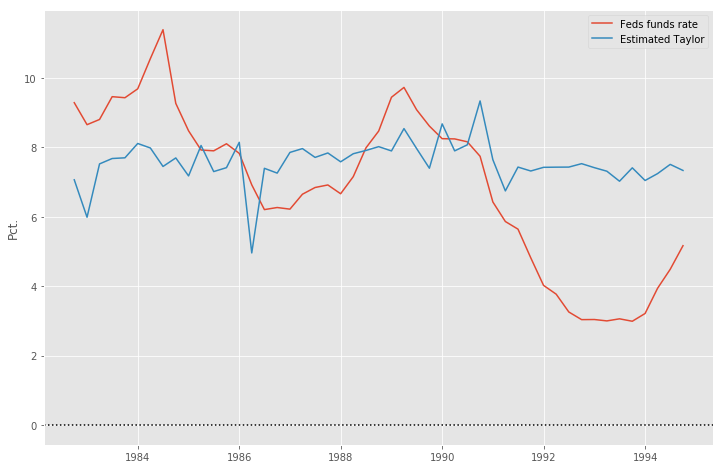

In [40]:
# 1) Import the print_function package.
from __future__ import print_function

# 2) Import the statsmodels package in order to estiamte the funds rate by OLS.
import statsmodels.formula.api as sm

# 3) Generate the inflation gap and the output gap. 
select_data.com_sel['ols_pi'] = (select_data.com_sel['pi'] - select_data.com_sel['pi_star'])*100
select_data.com_sel['ols_y'] = (select_data.com_sel['y']-select_data.com_sel['y_bar'])*100

# 4) Import the statsmodels package.                                      
from statsmodels.sandbox.regression.predstd import wls_prediction_std
                                              
# 5) Estimate the funds rate by OLS                                              
result = sm.ols(formula='i ~ ols_pi + ols_y', data=select_data.com_sel).fit()
                 
# 6) Store the estimated parameters. The 'ols' function saves the parameters as a series called 'params'.                                               
r_ols = result.params[0]
b_ols = result.params[1]
h_ols = result.params[2]

# 7) Make the list of the estimated parameters
ols_results = ['   ols' ,'{:6.3f}'.format(round(r_ols, 3)),'{:6.3f}'.format(round(b_ols, 3)), '{:6.3f}'.format(round(h_ols, 3))]

# 8) Print the estimated parameters.
for x,y,z,w in zip(guess_optimize.para, guess_optimize.result, mini_results, ols_results):
    print(x,y,z,w)

# 9) Graph the estimated Taylor and the Feds funds rate
graph(r_ols,b_ols,h_ols)

We note that the estimates when applying our own OLS estimator are identical to the OLS estimator from the `statsmodels` package. However, we note that the estimates when we optimize by drawing random number are different. This is due to the fact that one has to draw a very large set of different numbers in order to find the values that ensures the best fit. 

# Robustness check

We want to examine the robustness of our estimates. We notice that the estimates are very dependent of the choice of time period. This indicates that our results are in at least one way very sensitive. In the following, we estimate the parameters of $\bar{r}$, $b$ and $h$ with another price index. Afterwards, we estimate the parameters with a new definition of the Taylor rule. 

Previously, we have shown that the optimize function from the `scipy` package and the OLS estimator from the `statsmodels` package generate the same estimates. They are better methods than drawing random numbers and examine the fit, and they are also easier to apply (since someone has already created the function). Thus, we apply the OLS estimator from the `statsmodels` package when we examine the robustness of our estimates.

First, we examine if the estimates differ when we use another price index. We use the commodity price index instead of the consumer price index. In order to do that, we must import the data and structure it was we did earlier. 

In [41]:
# 1) Import data from the FRED-database. We want to import data from the same period as before if possible. 
cpi_com = web.DataReader('CUSR0000SAC', 'fred', start_cpi, end)

# 2) Calculate the relative change in the consumer price index three months before by applying the '.pct_change' function.
cpi_com['pi_com'] = cpi_com['CUSR0000SAC'].pct_change(periods=3)

# 3) Since the index is given by the DatetimeIndex, we apply the '.month' function in order to only 
# consider quarterly observations (to only consider quarterly data, we use observations from January (Q1), 
# April (Q2), July (Q3) and October (Q4). 
cpi_com = cpi_com[(cpi_com.index.month == 1) | (cpi_com.index.month == 4) | 
      (cpi_com.index.month == 7) | (cpi_com.index.month == 10)]

# 4) The first row of the inflation is "nan", and hence we only keep observations from row 1 and onwards.  
cpi_com = cpi_com.iloc[1:]

# 5) Take a copy of the dataset with the choice of time period in the beginning of the analysis.
select_data_commodity = select_data.com_sel.copy()

# 6) Set the index to "DATE" on the data set to this can be merged with the commodity inflation.
select_data_commodity.reset_index(inplace=True)
select_data_commodity.set_index('DATE', inplace=True)

# 7) Merges the data sets with the "join" function. We choose an "inner-join" in order to only keep observations
#   that are present in both data sets. 
rob_select_com = select_data_commodity.join(cpi_com, how='inner')

# 8) Drop variables that are irrelevant in this context. 
drop_com = ['CUSR0000SAC', 'index', 'taylor', 'error', 'error2']
rob_select_com.drop(drop_com, axis=1, inplace=True)

# 9) Calculate the inflation gap with the commodity price inflation. 
rob_select_com['ols_pi_com'] = (rob_select_com['pi_com'] - rob_select_com['pi_star'])*100

We plot the evolution of the commodity price inflation and compare it to the consumer price inflation.

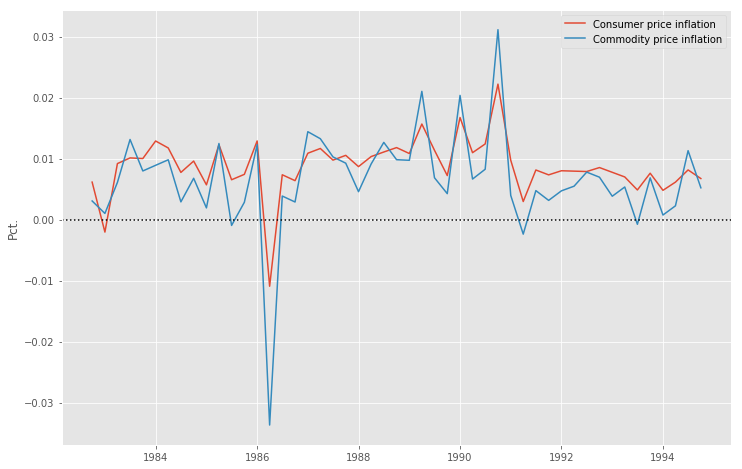

In [42]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.plot(rob_select_com['pi'])
plt.plot(rob_select_com['pi_com'])
plt.ylabel('Pct.')
plt.legend(['Consumer price inflation', 'Commodity price inflation'])
axes_com = plt.gca()
axes_com.axhline(y=0, color='black',linestyle=':')
plt.show()

We note that the commodity price inflation is more volatile. However, we conclude that the two different price indices evolve in the same way.

We estimate the parameters by OLS as mentioned before. We print the estimates in the bottom and compare it with the estimates when using the consumer price index.

In [43]:
# 1) Estimate the funds rate with the commodity price inflation by OLS.                                          
result_com = sm.ols(formula='i ~ ols_pi_com + ols_y', data=rob_select_com).fit()

# 2) Store the estimated parameters. The 'ols' function saves the parameters as a series called 'params'.             
r_ols_com = result_com.params[0]
b_ols_com = result_com.params[1]
h_ols_com = result_com.params[2]

# 3) Make the list of the estimated parameters
ols_results_com = ['ols_com' ,'{:6.3f}'.format(round(r_ols_com, 3)),'{:6.3f}'.format(round(b_ols_com, 3)), '{:6.3f}'.format(round(h_ols_com, 3))]

# 4) Print the estimates and compare with estimates from OLS estimation with consumer price index.
for aa, bb, cc in zip(guess_optimize.para, ols_results, ols_results_com):
    print(aa, bb, cc)

     ols ols_com
r  7.114  7.266
b  1.333  0.512
h  0.027  0.094


We note that the estimate of $b$ is generally lower when one uses commodity price inflation compared to consumer price inflation (this is true in most cases, but since one can choose the time period, this might not always be the case). As we concluded before, the commodity price inflation is more volatile than the consumer price inflation. Thus, when we know the true funds rate, this means that the central bank will react to changes in the output gap to a lesser extent. In this case, $\hat{b}_{CPI}>\hat{b}_{COMPI}$ is true by definition.

$\hat{\bar{r}}$ and $\hat{h}$ are only affected in a minor way when the inflation changes from consumer price inflation to commodity price inflation.

In the recent years, some economists have proposed new versions of the Taylor rule. Surico (2002) has defined an extended Taylor rule where he includes the quadratic gap. The quadratic gap is the squared output gap, and by including this, we make it possible that the central bank can react differently with respect to the funds rate to a boom compared to a recession. This implies that we now take asymmetric preferences of the central bank into account. 

The extended Taylor rule is given by

$i_t = \bar{r} + b(\pi_t - \pi^*) + h(y_t - \bar{y}) + z(y_t - \bar{y})^2 + \epsilon _t$

where $z$ shows the degree of asymmetric preferences of the central bank. The rest of the parameters and values are identical to the definition in the introduction.

We note that if $z=0$, the central bank does not have asymmetric preferences. If $z>0$, the central bank reacts stronger with respect to the funds rate to a recession than to a boom. If $z<0$, the central bank reacts stronger to a boom than to a recession.

In order to estimate the equation, we calculate the quadratic gap and structure data. Again, we conduct estimate the parameters for the same time period as chosen in the analysis.

In [44]:
# 1) Copy the data set with the selected time period.
rob_select_quad = select_data.com_sel.copy()

# 2) Set index to date. 
rob_select_quad.reset_index(inplace=True)
rob_select_quad.set_index('DATE', inplace=True)

# 3) Drop irrelevant variables. 
drop_quad = ['index', 'taylor', 'error', 'error2']
rob_select_quad.drop(drop_quad, axis=1, inplace=True)

# 4) Calculate the quadratic gap. 
rob_select_quad['ols_quad'] = rob_select_quad['ols_y']**2

We are now able to estimate the parameters. We use the OLS estimator in the same way as before and print the table of all the OLS estimations in the bottom.

In [45]:
# 1) Estimate the funds rate with the commodity price inflation by OLS.                                          
result_quad = sm.ols(formula='i ~ ols_pi + ols_y + ols_quad', data=rob_select_quad).fit()

# 2) Store the estimated parameters. The 'ols' function saves the parameters as a series called 'params'.             
r_ols_quad = result_quad.params[0]
b_ols_quad = result_quad.params[1]
h_ols_quad = result_quad.params[2]
z_ols_quad = result_quad.params[3] 

# 3) Define the parameters.
result_quad.para = [' ','r','b','h','z']

# 4) Insert the value of z_hat (missing) in the two previus estimations.
ols_results_new = ols_results.copy()
ols_results_new.append('   -   ')
ols_results_com_new = ols_results_com.copy()
ols_results_com_new.append('   - ')

# 5) Make the list of the estimated parameters
ols_results_quad = ['ols_quad' ,'{:6.3f}'.format(round(r_ols_quad, 3)),'{:6.3f}'.format(round(b_ols_quad, 3)), '{:6.3f}'.format(round(h_ols_quad, 3)), '{:6.3f}'.format(round(z_ols_quad, 3))]

# 6) Print the estimates and compare with estimates from OLS estimation with consumer price index.
for aa, bb, cc, dd in zip(result_quad.para, ols_results_new, ols_results_com_new, ols_results_quad):
    print(aa, bb, cc, dd)

     ols ols_com ols_quad
r  7.114  7.266  8.944
b  1.333  0.512  1.381
h  0.027  0.094  1.889
z    -       -   0.282


The estimates of $\bar{r}$ and $h$ are not really affected when one uses the commodity price index instead of the consumer price index. The estimate of $b$ is lower when one includes the commodity price index, since it is more volatile, and the central bank will thus respond to a lesser extent. 

When we include the quadratic gap, the estimate of $b$ is almost identical from the baseline model. However, the estimate of $h$ changes a lot, since we not include the squared output gap. 

# Conclusion

In this project, we have examined if the FED has set the interest rate according to the Taylor rule. We find that the FED has set the funds rate according to the Taylor rule in subperiods, but that if we consider the whole period, the estimated funds rate is very different from the actual funds rate. This is not surprising since we consider a span of more than 60 years where the structures of the economy have changed significantly (different inflation targets, financial crisis, etc.). Furthermore, this implies that the estimates of $\bar{r}$, $b$ and $h$ are time-dependent. We note that $\frac{b}{h}$ is lower if we consider periods closer to today. This suggests that the central bank weights the output gap higher relative to the inflation gap today than before. 

We have estimated $\bar{r}$, $b$ and $h$ by three different methods. All three methods minimize the difference between the actual funds rate and the estimated funds rate. We note from the table in the end that the minimize function from the `scipy` package and the OLS-estimator from the `statsmodels` package generate the same estimates. When we increase the number of iterations, we are able to get almost the same estimates from drawing a different set of parameter values until these have minimized the difference between the actual funds rate and the estimated funds rate. 

The estimates are not robust if we use the commodity price index instead of the consumer price index, or if we include the quadratic gap in the estimation. Thus, we conclude that the estimates are very sensitive to the choice of time period and to the choice of variables included.